# Which language is it ?

*Par Masse Océane & Daudré--Treuil Prunelle*

**Un projet de NLP dans le cadre de l'UE Sciences des Données 2 de la Licence MIASHS**

Dans le présent projet, nous cherchons à classifier du texte en fonction de leur langue en utilisant la fréquence d'utilisation des lettres et bigrammes dans les différentes langues. Le présent document présentera comment nous avons pu collecter nos données sur wikipedia en utilisant les librairies requests et BeautifulSoup, puis une partie d'exploration des données. Enfin nous testerons plusieurs modèles de classification tout en cherchant à déterminer leurs paramètres.

<a id="menu"></a>

## Plan :
1. [Collecte des données](#title1)
    1. [Données utilisées](#subtitle1.1)
    2. [Scrapper](#subtitle1.2)
    3. [Collecte de données](#subtitle1.3)
2. [Exploration des données](#title2)
    1. [Lettres](#subtitle2.1)
    2. [Bigrammes](#subtitle2.2)
    3. [Distances](#subtitle2.3)
    4. [Lettres (suite)](#subtitle2.4)
    5. [Bigrammes (suite)](#subtitle2.5)
3. [Constitution des ensembles d'entraînement](#title3)
4. [Classifieur par k-plus proches voisins](#title4)
5. [Classifieur bayésien](#title5)
6. [Classifieur par forêt aléatoire](#title6)
    

In [16]:
# A different regex library
import regex as re

# The usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# The libraries for the scrapping
import requests
from bs4 import BeautifulSoup

# A little bit of scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# The libraries for the progress bars
from tqdm import tqdm
import sys

# And finally our own libraries
from functions.collecteDonnees import *
from functions.explorationDonnees import *
from functions.entrainementClassifieur import *

# Most of these libraries are not really use in this notebook but in our own libraries, we still
# put them here for a better understanding of the tools we used.

<a id="title1"></a>
## Collecte des données : [(Sommaire)](#menu)

Toutes les fonctions de cette partie sont à retrouver dans le fichier *collecteDonnees.py*.

<a id="subtitle1.1"></a>
### Données utilisées :

Nous avons décidé de travailler sur les données suivantes :

* **Langues :** *Français*, *Anglais*, *Italien*, le but ici est de choisir des langues utilisant l'alphabet latin, ayant des pages wikipédia longues et nombreuses et n'étant pas trop proches : une langue germanique, une langue romane et notre langue maternelle afin de pouvoir comprendre ce qu'il se passe quand nous effectuons des tests


* **Textes :** Nous utilisons ici les pages wikipédia des sujets suivants : *Dragon*, *Loup* et *Noam Chomsky*. Nous avons essayé de trouver des pages assez longues et diverses

In [17]:
lang = ["fr", "gb", "it"]
URL_l = {"fr":["https://fr.wikipedia.org/wiki/Dragon", 
               "https://fr.wikipedia.org/wiki/Canis_lupus",
               "https://fr.wikipedia.org/wiki/Noam_Chomsky"],
         "gb":["https://en.wikipedia.org/wiki/Dragon",
               "https://en.wikipedia.org/wiki/Wolf",
               "https://en.wikipedia.org/wiki/Noam_Chomsky"],
         "it":["https://it.wikipedia.org/wiki/Drago",
               "https://it.wikipedia.org/wiki/Canis_lupus",
               "https://it.wikipedia.org/wiki/Noam_Chomsky"]}
name_l = ["dragon", "loup", "chomsky"]

<a id="subtitle1.2"></a>
### Scrapper :[(Sommaire)](#menu)

Nous utilisons ici les librairies requests et bs4 afin de récupérer le contenu des pages wikipédia. 

Voici les fonctions utilisées :

* *get_paragraphs :* Récupère le texte d'une page wikipédia donnée et la stocke dans un fichier à part.


* *get_clean_txt :* Nettoye un texte précédemment récupéré et le retourne sous la forme d'une liste de mots, à l'aide du regex "[a-zA-Z]+".


* *n_grams_frequencies :* Découpe le texte nettoyé en n-grams et retourne un dictionnaire de leur fréquences, en utilisant le regex "[a-zA-Z]{{{}}}".


* *data_collect :* Pour une langue donnée, se charge de faire appel aux fonction précédentes afin de récupérer les textes des pages wikipédias et de retourner le dictionnaire complet de toutes les fréquences de n-grams.



<a id="subtitle1.3"></a>
### Collecte de données : [(Sommaire)](#menu)

<a id="subtitle1.31"></a>
#### Lettres :

Nous allons ici créer un dictionnaire de toutes nos fréquences par lettres et par langues utilisant toutes nos fonctions.

In [18]:
freq_n1 = {}
freq_n1[lang[0]] = data_collect(lang, URL_l, name_l, 0, 1) # French letters
freq_n1[lang[1]] = data_collect(lang, URL_l, name_l, 1,1) # English letters
freq_n1[lang[2]] = data_collect(lang, URL_l, name_l, 2,1) # Italian letters

Langue it, 1-grams: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s]


<a id="subtitle1.32"></a>
#### Bi-grammes [(Sommaire)](#menu)

Nous allons ici créer un dictionnaire de toutes nos fréquences par bigrammes et par langues utilisant toutes nos fonctions.

In [19]:
freq_n2 = {}
freq_n2[lang[0]] = data_collect(lang, URL_l, name_l,0,2) # French letters
freq_n2[lang[1]] = data_collect(lang, URL_l, name_l,1,2) # English letters
freq_n2[lang[2]] = data_collect(lang, URL_l, name_l,2,2) # Italian letters

Langue it, 2-grams: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s]


<a id="title2"></a>
## Exploration des données [(Sommaire)](#menu)

Toutes les fonctions de cette partie sont à retrouver dans le fichier *explorationDonnees.py*.

Nous avons commencer par créer quelques fonctions pour automatiser l'affichage : *freq_show*, *freq_all_show* et *freq_partial_show*, ces fonctions permettant de choisir entre afficher toutes les fréquences et n'en afficher qu'une partie.

<a id="subtitle2.1"></a>
### Lettres[(Sommaire)](#menu)

Nous allons ici afficher nos fréquences par lettres et langues afin de sélectionner à partir de quelles lettres créer nos vecteurs. Pour cela nous cherchons des lettres ayant à la fois une haute fréquence pour au moins une langue et une grosse différence de fréquences entre les langues. Nous sélectionnons pour l'instant les lettres visuellements.

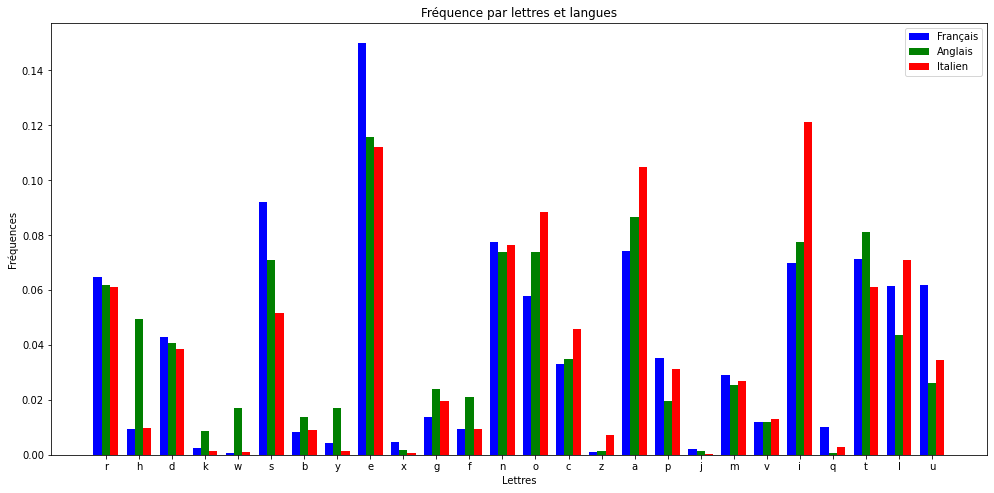

In [20]:
freq_all_show(freq_n1, "lettres", 'Lettres', 'lettres1.png')

Les lettres choisies sont :

* e car il est significatif pour le français


* i car il est significatif en italien


* h, w, y car ils sont significatifs en anglais, on en prend plusieurs car c'est des plus petites fréquences


<a id="subtitle2.2"></a>
### Bigrammes [(Sommaire)](#menu)

Nous allons ici afficher nos fréquences par bigrammes et langues afin de sélectionner à partie de quelles bigrammes créer nos vecteurs. Pour cela nous cherchons des bigrammes ayant à la fois une haute fréquence pour au moins une langue et une grosse différence de fréquences entre les langues. Nous sélectionnons pour l'instant les bigrammes visuellements.

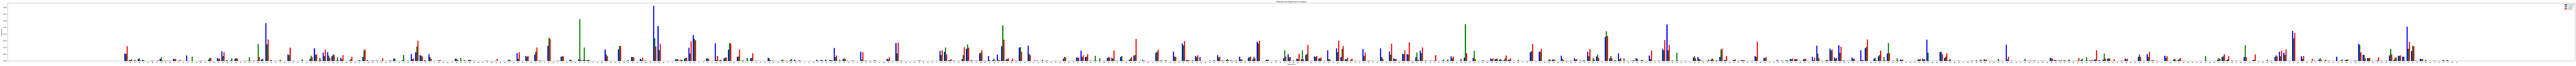

In [21]:
freq_all_show(freq_n2, "bigrammes", 'Bigrammes', 'bigrammes1.png')

Affichons seulement une sélection :

* et, ur, nt, es, le, en et de pour le français


* co, no, ne, of, ll et di pour l'italien


* in, ed, wi, ea, er, et th pour l'anglais

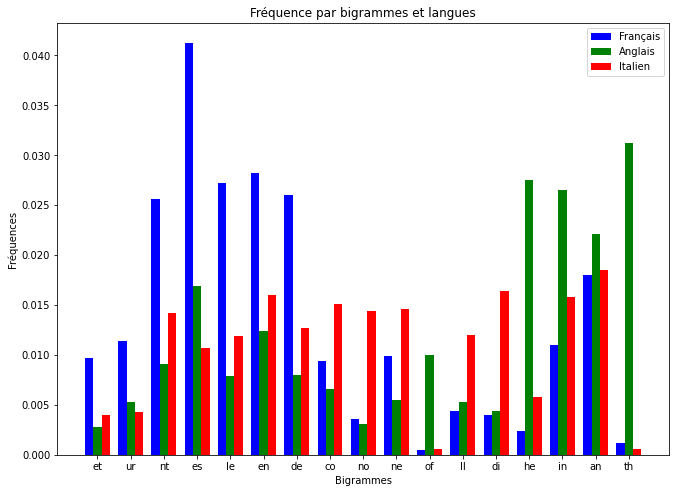

In [22]:
selection = ["et", "ur", "nt", "es", "le", "en", "de",
          "co", "no", "ne", "of", "ll", "di",
          "he", "in", "an", "th"]
freq_partial_show(selection, freq_n2, "bigrammes", 'Bigrammes', 'bigrammes2.png')

<a id="subtitle2.3"></a>
### Distance [(Sommaire)](#menu)

Afin de rendre notre sélection un peu plus mathématiques, nous allons nous intéresser à la distance entre la fréquence d'une langue et la fréquence maximum des deux autres langues afin de maximiser l'écart entre les fréquences. Pour cela nous utiliserons les fonctions suivantes :

* *min_dist :* Calcule la plus petite distance entre un point et deux autres points.


* *dist_dict :* Calcule toutes les distances entre les n-grammes des différentes langues.


* *show_dist :* Affiche le graphique des distances entre n-grammes.


* *ngrams_choice :* Trie les distances et retourne les k plus grandes distances entre les n-grammes pour chaque langue afin de sélectionner automatiquement les n-grammes les plus significatifs.


<a id="subtitle2.4"></a>
### Lettres (suite) [(Sommaire)](#menu)

Commençons par afficher le graph des distances :

Calcul des distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 262144.00it/s]


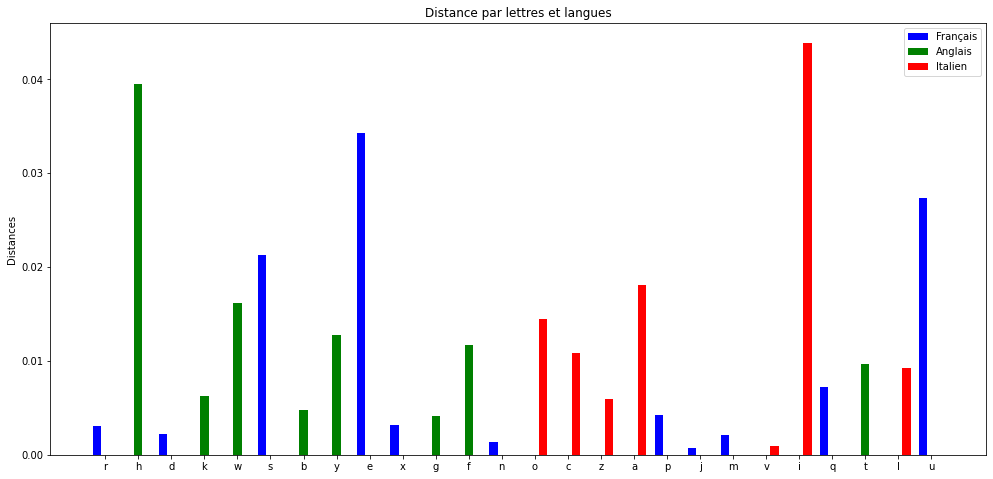

In [23]:
show_dist(freq_n1, "lettres", "Distances_lettres")

Utilisons maintenant la fonction *ngrams_choice* pour choisir les lettres :

In [24]:
letters_list = ngrams_choice(freq_n1,4)
letters_list

Calcul des distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 247283.23it/s]


['e', 'u', 's', 'q', 'h', 'w', 'y', 'f', 'i', 'a', 'o', 'c']

Et enfin affichons les frequences des lettres sélectionnées :

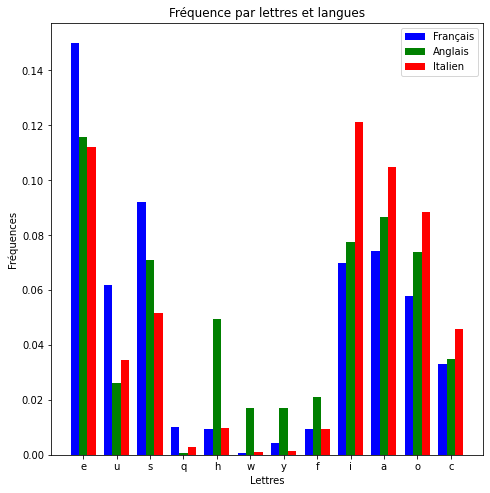

In [25]:
freq_partial_show(letters_list, freq_n1, "lettres", 'Lettres', 'lettres2.png')

<a id="subtitle2.5"></a>
### Bigrammes (suite) [(Sommaire)](#menu)

Commençons par afficher le graph des distances :

Calcul des distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 419826.46it/s]


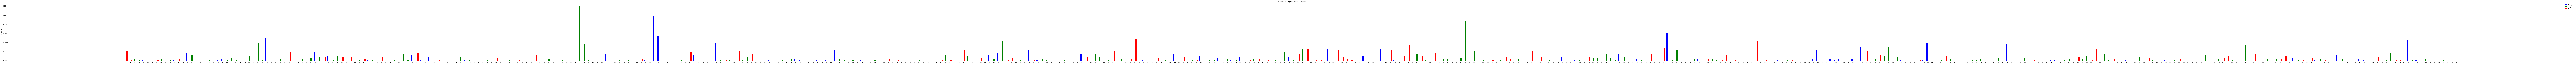

In [26]:
show_dist(freq_n2, "bigrammes", "Distances_bigrammes1")

Utilisons maintenant la fonction *ngrams_choice* pour choisir les bigrammes :

In [27]:
bigrams_list=ngrams_choice(freq_n2,4)
bigrams_list

Calcul des distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 327294.04it/s]


['es', 'le', 'de', 'en', 'th', 'he', 'in', 'ed', 'di', 'no', 'el', 'ri']

Et enfin affichons les frequences des bigrammes sélectionnées :

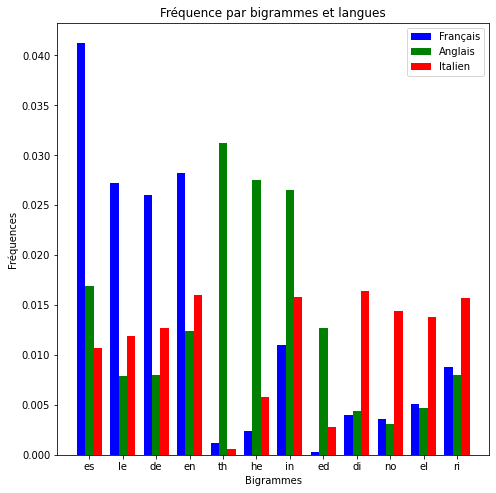

In [28]:
freq_partial_show(bigrams_list, freq_n2, "bigrammes", 'Bigrammes', 'bigrammes3.png')

<a id="title3"></a>
## Constitution des ensembles d'entraînement [(Sommaire)](#menu)

Toutes les fonctions de cette partie sont à retrouver dans le fichier *entrainementClassifieur.py*.

Afin de constituer un ensemble d'entrainement, nous utiliserons les fonctions suivantes :

* *get_n_grams :* Récupére le fichier contenant une page wikipédia, et retourne la liste des n-grammes, on utilise également ce regex "[a-zA-Z]{{{}}}".


* *cut :* Découpe le texte en morceaux d'une longueur de *l_min* n-grammes.


* *vect :* Convertit un morceau parmis les morceaux précédemment découpés en vecteur grace aux n-grammes précédemment sélectionnés comme significatifs.


* *convert_list_text :* Convertit tous les morceaux précédemment découpés en vecteurs.


* *build_X_y :* Construit notre domaines des entrées à partir des vecteurs précédemment créés et notre espace des étiquettes en associant un entier pour chacun des vecteurs, "1" pour le français, "2" pour l'anglais et "3" pour l'italien.


Nous avons donc un domaine des entrées de la forme : $$X = [0; 1[^d$$ avec *d* le nombre de vecteurs.

Et un espace des étiquettes de la forme : $$Y = \{1; 2; 3\}^d$$

<a id="title4"></a>
## Classifieur par k-plus proches voisins : [(Sommaire)](#menu)

Dans le même fichier que précédemment, nous avons placé les fonctions suivantes :

* *knn_step :* Permettant de lancer et tester un classifieur selon des paramètres précis. Cette fonction retournera les erreurs empirique et en généralisation.


* *l_min_find :* Permettant d'afficher les erreurs empiriques et en généralisation en fonction de *l_min* la longueur des vecteurs.


* *n_find :* Permettant d'afficher les erreurs empiriques et en généralisation en fonction du nombre de n-grammes par langue.


* *neighbors_find :* Permettant d'afficher les erreurs empiriques et en généralisation en fonction du nombre de voisins utilisés par le classifieur.


<a id="subtitle4.1"></a>
### Selections des paramètres : [(Sommaire)](#menu)
<a id="subtitle4.11"></a>
#### Choix de l_min :

Nous commencons par fixer le nombre de voisins à 42 et le nombre de n-grams à 2 par langues afin de chercher quel *l_min* nous pouvons utiliser. Nous effectuerons cette opération pour les lettres et pour les bigrammes.

Recherche de l_min: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:49<00:00, 14.18s/it]


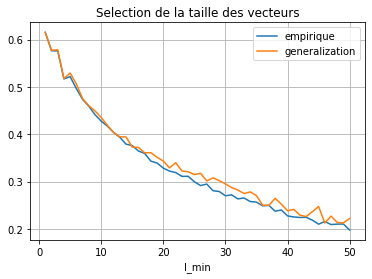

In [29]:
lettres = ngrams_choice(freq_n1,2)
l_min_find(lettres, 1, 51, 42,"L_min1",1)

Recherche de l_min: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:57<00:00, 14.36s/it]


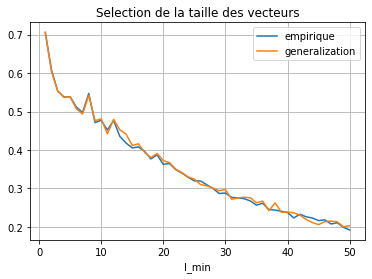

In [30]:
bigrammes = ngrams_choice(freq_n2,2)
l_min_find(bigrammes, 2, 51, 42,"L_min2",1)

Nous voulons ici choisir un *l_min* correspondant à la plus petite longueur  permettant d'obtenir un taux d'erreur inférieur à 25%. Prenons : 

$$ l\_min = 50 \quad lettres $$ et $$ l\_min = 40 \quad bigrammes $$

<a id="subtitle4.12"></a>
#### Choix du nombre de lettres :

Nous fixons donc *l_min* à 50 pour les lettres et 40 pour les bigrammes, le nombre de voisins restant arbitrairement fixé à 42. Nous cherchons maintenant à choisir le nombre de n-grammes utilisés par langues, toujours pour les lettres et les bigrammes.

Recherche du nombre de n-grams: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


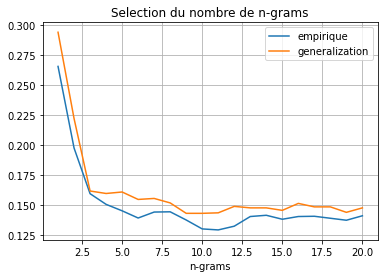

In [31]:
n_find(lang, URL_l, name_l,21, 1, 50, 42,"Nb_grams1", 1, False)

In [32]:
ngrams_choice(freq_n1,10)

Calcul des distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 248976.95it/s]


['e',
 'u',
 's',
 'q',
 'p',
 'x',
 'r',
 'd',
 'm',
 'n',
 'h',
 'w',
 'y',
 'f',
 't',
 'k',
 'b',
 'g',
 'z',
 'x',
 'i',
 'a',
 'o',
 'c',
 'l',
 'z',
 'v',
 'y',
 'x',
 'w']

Recherche du nombre de n-grams: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


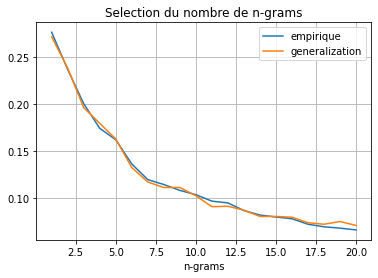

In [33]:
n_find(lang, URL_l, name_l,21, 2, 40, 42,"Nb_grams2",1 ,False)

In [34]:
ngrams_choice(freq_n2,8)

Calcul des distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 364124.67it/s]


['es',
 'le',
 'de',
 'en',
 'nt',
 'ou',
 'qu',
 'ue',
 'th',
 'he',
 'in',
 'ed',
 'of',
 'ng',
 'nd',
 'ea',
 'di',
 'no',
 'el',
 'ri',
 'll',
 'pi',
 'ia',
 'ta']

Nous sélectionnons ici un nombre de n-grammes par langue correspondant au plus petit possible parmis ceux permettant d'obtenir un taux d'erreur inférieur à 12%. Prenons : 

$$ sélection = 10 \quad lettres \quad par \quad langues $$ soit $$ [e, u, s, q, p, x, r, d, m, n, h, w, y, f, t, k, b, g, z, x, i, a, o, c, l, z, v, y, x, w]$$ et $$ sélection = 8 \quad bigrammes \quad par \quad langues $$ soit $$ [es, le, de, en, nt, ou, qu, ue, th, he, in, ed, of, ng, nd, ea, di, no, el, ri, ll, pi, ia, ta]$$

<a id="subtitle4.13"></a>
#### Choix du nombre de voisins :

Nous allons enfin déterminer le nombre de voisin pour le knn pour les lettres et les bigrammes. Nous fixons donc *l_min* toujours à 20 pour les lettres et 25 pour les bigrammes, le nombre de lettres par langue à 3 et le nombre de bigrammes par langue à 4.

Recherche du nombres de voisins: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.46s/it]


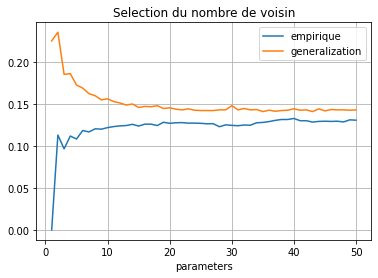

In [35]:
lettres = ngrams_choice(freq_n1,10)
neighbors_find(lettres, 1, 50, 51, 1,"Nb_voisins1")

Recherche du nombres de voisins: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:02<00:00,  1.25s/it]


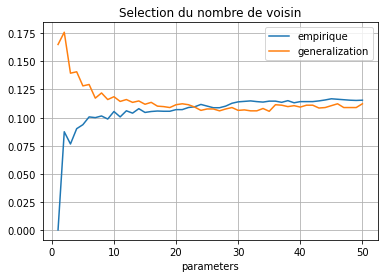

In [36]:
bigrammes = ngrams_choice(freq_n2,8)
neighbors_find(bigrammes, 2, 40, 51, 1, "Nb_voisins2")

Nous observons ici que l'erreur se stabilise entre 10 et 15% autant pour les lettres que pour les bigrammes. Nous sélectionnerons ici un nombre de voisin suffisant pour que les erreurs convergent suffisament mais pas trop élevé afin de garder une complexité relativement faible : 

$$ nombre \quad de \quad voisins = 20 \quad voisins \quad pour \quad les \quad lettres $$ et $$ nombre \quad de \quad voisins = 15 \quad voisins \quad pour \quad les \quad bigrammes $$

Testons maintenant nos classifieurs avec les paramètres testés :

In [37]:
files = ["fr_dragon", "gb_dragon", "it_dragon", "fr_chomsky", "gb_chomsky", "it_chomsky", "fr_loup", "gb_loup", "it_loup"]
lettres = ngrams_choice(freq_n1,10)
knn_step(lettres, files, 50, 1, 20)

Calcul des distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 158736.40it/s]


(0.1273439109828972, 0.14585908529048208)

In [38]:
files = ["fr_dragon", "gb_dragon", "it_dragon", "fr_chomsky", "gb_chomsky", "it_chomsky", "fr_loup", "gb_loup", "it_loup"]
bigrammes = ngrams_choice(freq_n2,8)
knn_step(bigrammes, files, 40, 2, 15)

Calcul des distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 348867.09it/s]


(0.10463659147869675, 0.11189979123173277)

En résumé : | Lettres : | Bigrammes : 
 --- | --- | --- 
l_min | 50 | 40
Sélection | 30 lettres | 24 bigrammes 
Voisins | 20 | 15
Erreur empirique | 13% | 11%
Erreur en généralisation | 15% | 11%

<a id="title5"></a>
## Classifieur bayésien : [(Sommaire)](#menu)

Toujours dans le même fichier, nous avons rajouter la fonction *gnb_step* ayant la même utilité que *knn_step* mais pour un classifieur bayésien. Pour le reste, nous utilisons les mêmes fonctions.

### Selections des paramètres : [(Sommaire)](#menu)
#### Choix de l_min :

Nous commencons par fixer le nombre de n-grams à 2 par langues afin de chercher quel *l_min* nous pouvons utiliser. Nous effectuerons cette opération pour les lettres et pour les bigrammes.

Recherche de l_min: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.42it/s]


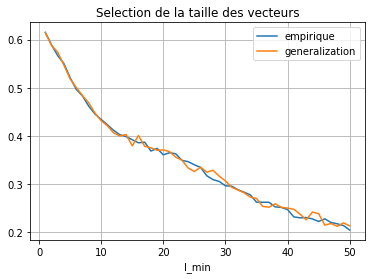

In [39]:
lettres = ngrams_choice(freq_n1,2)
l_min_find(lettres, 1, 51, 0,"L_min3",2)

Recherche de l_min: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.24it/s]


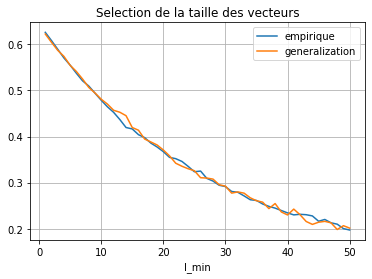

In [40]:
bigrammes = ngrams_choice(freq_n2,2)
l_min_find(bigrammes, 2, 51, 0,"L_min4",2)

Nous voulons ici choisir un *l_min* correspondant à la plus petite longueur  permettant d'obtenir un taux d'erreur inférieur à 25%. Prenons : 

$$ l\_min = 50 \quad lettres $$ et $$ l\_min = 50 \quad bigrammes $$

<a id="subtitle4.12"></a>
#### Choix du nombre de lettres :

Nous fixons donc *l_min* à 50 pour les lettres comme pour les bigrammes. Nous cherchons maintenant à choisir le nombre de n-grammes utilisés par langues, toujours pour les lettres et les bigrammes.

Recherche du nombre de n-grams: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.16it/s]


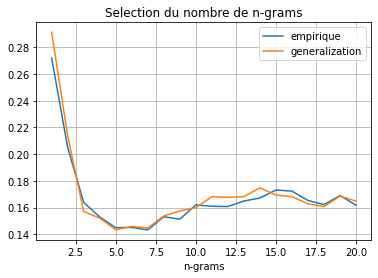

In [41]:
n_find(lang, URL_l, name_l,21, 1, 50, 0,"Nb_grams3", 2, False)

In [42]:
ngrams_choice(freq_n1,6)

Calcul des distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 136485.49it/s]


['e',
 'u',
 's',
 'q',
 'p',
 'x',
 'h',
 'w',
 'y',
 'f',
 't',
 'k',
 'i',
 'a',
 'o',
 'c',
 'l',
 'z']

Recherche du nombre de n-grams: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.57it/s]


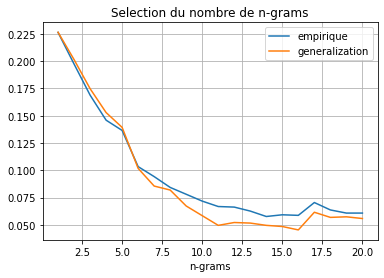

In [43]:
n_find(lang, URL_l, name_l,21, 2, 50, 0,"Nb_grams4",2 ,False)

In [44]:
ngrams_choice(freq_n2,10)

Calcul des distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 424800.52it/s]


['es',
 'le',
 'de',
 'en',
 'nt',
 'ou',
 'qu',
 'ue',
 'eu',
 'au',
 'th',
 'he',
 'in',
 'ed',
 'of',
 'ng',
 'nd',
 'ea',
 'wo',
 'ha',
 'di',
 'no',
 'el',
 'ri',
 'll',
 'pi',
 'ia',
 'ta',
 'co',
 'ra']

Nous sélectionnons ici un nombre de n-grammes par langue correspondant au plus petit possible parmis ceux permettant d'obtenir un taux d'erreur inférieur à 15% pour les lettres et 7,5% pour les bigrammes. Prenons : 

$$ sélection = 6 \quad lettres \quad par \quad langues $$ soit $$ [e, u, s, q, p, x, h, w, y, f, t, k, i, a, o, c, l, z]$$ et $$ sélection = 10 \quad bigrammes \quad par \quad langues $$ soit $$ [es, le, de, en, nt, ou, qu, ue, eu, au, th, he, in, ed, of,$$ $$ ng, nd, ea, wo, ha, di, no, el, ri, ll, pi, ia, ta, co, ra]$$

Testons maintenant nos classifieurs avec les paramètres testés :

In [45]:
files = ["fr_dragon", "gb_dragon", "it_dragon", "fr_chomsky", "gb_chomsky", "it_chomsky", "fr_loup", "gb_loup", "it_loup"]
lettres = ngrams_choice(freq_n1,6)
gnb_step(lettres, files, 50, 1)

Calcul des distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 247845.24it/s]


(0.14506490830414176, 0.14585908529048208)

In [46]:
files = ["fr_dragon", "gb_dragon", "it_dragon", "fr_chomsky", "gb_chomsky", "it_chomsky", "fr_loup", "gb_loup", "it_loup"]
bigrammes = ngrams_choice(freq_n2,10)
gnb_step(bigrammes, files, 50, 2)

Calcul des distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 427496.37it/s]


(0.07180156657963443, 0.05845511482254695)

En résumé : | Lettres : | Bigrammes : 
 --- | --- | --- 
l_min | 50 | 50
Sélection | 18 lettres | 30 bigrammes 
Erreur empirique | 15% | 7%
Erreur en généralisation | 15% | 6%

<a id="title6"></a>
## Classifieur par forêt aléatoire

Toujours dans le même fichier, nous avons rajouter la fonction *clf_step* ayant la même utilité que *knn_step* et *gnb_step* mais pour un classifieur bayésien. Pour le reste, nous utilisons les mêmes fonctions. La fonction n_find serviront alors à trouver le nombre d'estimateurs à utiliser au lieu du nombre de voisins.

### Selections des paramètres : [(Sommaire)](#menu)
#### Choix de l_min :

Nous commencons par fixer le nombre d'estimateurs à 42 et le nombre de n-grams à 2 par langues afin de chercher quel *l_min* nous pouvons utiliser. Nous effectuerons cette opération pour les lettres et pour les bigrammes.

Recherche de l_min: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]


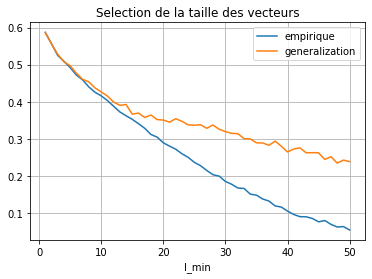

In [47]:
lettres = ngrams_choice(freq_n1,2)
l_min_find(lettres, 1, 51, 42,"L_min5",3)

Recherche de l_min: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.60it/s]


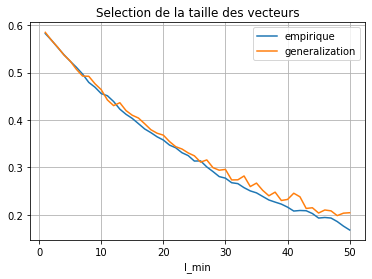

In [48]:
bigrammes = ngrams_choice(freq_n2,2)
l_min_find(bigrammes, 2, 51, 42,"L_min6",3)

Nous voulons ici choisir un *l_min* correspondant à la plus petite longueur  permettant d'obtenir un taux d'erreur inférieur à 30%. Prenons : 

$$ l\_min = 50 \quad lettres $$ et $$ l\_min = 40 \quad bigrammes $$

<a id="subtitle4.12"></a>
#### Choix du nombre de lettres :

Nous fixons donc *l_min* à 50 pour les lettres et  bigrammes, le nombre d'estimateurs restant arbitrairement fixé à 42. Nous cherchons maintenant à choisir le nombre de n-grammes utilisés par langues, toujours pour les lettres et les bigrammes.

Recherche du nombre de n-grams: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.24it/s]


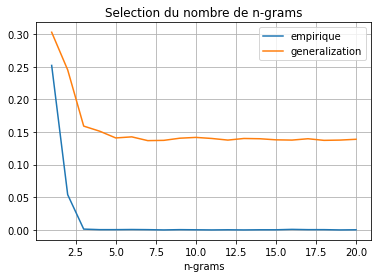

In [49]:
n_find(lang, URL_l, name_l,21, 1, 50, 42,"Nb_grams5", 3, False)

In [50]:
ngrams_choice(freq_n1,5)

Calcul des distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 218979.73it/s]


['e', 'u', 's', 'q', 'p', 'h', 'w', 'y', 'f', 't', 'i', 'a', 'o', 'c', 'l']

Recherche du nombre de n-grams: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.79it/s]


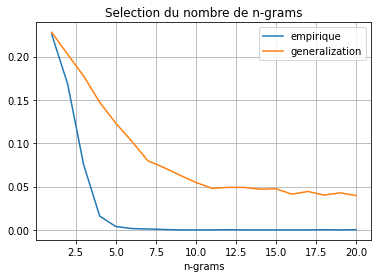

In [51]:
n_find(lang, URL_l, name_l,21, 2, 50, 42,"Nb_grams6", 3, False)

In [52]:
ngrams_choice(freq_n2,8)

Calcul des distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 327486.91it/s]


['es',
 'le',
 'de',
 'en',
 'nt',
 'ou',
 'qu',
 'ue',
 'th',
 'he',
 'in',
 'ed',
 'of',
 'ng',
 'nd',
 'ea',
 'di',
 'no',
 'el',
 'ri',
 'll',
 'pi',
 'ia',
 'ta']

Nous observons ici une convergence des deux erreurs, nous sélectionnerons alors le plus petit nombre de n-grammes permettant d'obtenir ces taux d'erreurs stables.. Prenons : 

$$ sélection = 5 \quad lettres \quad par \quad langues $$ soit $$ [e, u, s, q, p, h, w, y, f, t, i, a, o, c, l]$$ et $$ sélection = 8 \quad bigrammes \quad par \quad langues $$ soit $$ [es, le, de, en, nt, ou, qu, ue, th, he, in, ed, of, ng, nd, ea, di, no, el, ri, ll, pi, ia, ta]$$

<a id="subtitle4.13"></a>
#### Choix du nombre de voisins :

Nous allons enfin déterminer le nombre d'estimateurs pour la forêt pour les lettres et les bigrammes. Nous fixons donc *l_min* toujours à 50 pour les lettres e bigrammes, le nombre de lettres par langue à 5 et le nombre de bigrammes par langue à 8.

Recherche du nombres de voisins: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  3.87it/s]


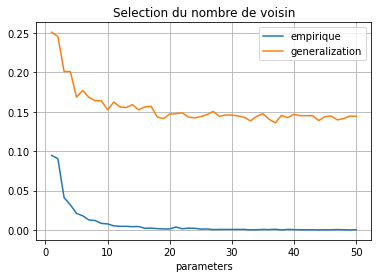

In [53]:
lettres = ngrams_choice(freq_n1,5)
neighbors_find(lettres, 1, 50, 51, 3,"Nb_voisins5")

Recherche du nombres de voisins: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.82it/s]


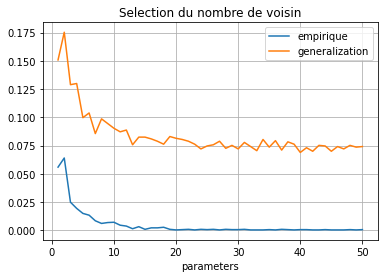

In [54]:
bigrammes = ngrams_choice(freq_n2,8)
neighbors_find(bigrammes, 2, 50, 51, 3, "Nb_voisins6")

Nous observons ici que l'erreur en généralisation se stabilise vers 15% pour les lettres et 7,5% pour les bigrammes. Nous sélectionnerons ici un nombre de voisin suffisant pour que les erreurs convergent suffisament mais pas trop élevé afin de garder une complexité relativement faible : 

$$ nombre \quad d'éstimateurs = 15 \quad voisins \quad pour \quad les \quad lettres $$ et $$ nombre \quad d'éstimateurs = 20 \quad voisins \quad pour \quad les \quad bigrammes $$

Testons maintenant nos classifieurs avec les paramètres testés :

In [59]:
files = ["fr_dragon", "gb_dragon", "it_dragon", "fr_chomsky", "gb_chomsky", "it_chomsky", "fr_loup", "gb_loup", "it_loup"]
lettres = ngrams_choice(freq_n1,15)
clf_step(lettres, files, 50, 1, 10)

Calcul des distances: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 153162.79it/s]


(0.008036266227075983, 0.16069221260815825)

In [60]:
files = ["fr_dragon", "gb_dragon", "it_dragon", "fr_chomsky", "gb_chomsky", "it_chomsky", "fr_loup", "gb_loup", "it_loup"]
lettres = ngrams_choice(freq_n2,20)
clf_step(lettres, files, 50, 2, 10)

Calcul des distances: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:00<00:00, 359298.71it/s]


(0.0013054830287205776, 0.0589770354906054)

En résumé : | Lettres : | Bigrammes : 
 --- | --- | --- 
l_min | 50 | 50
Sélection | 18 lettres | 30 bigrammes
Estimateurs | 5 | 10
Erreur empirique | 0,8% | 0,2%
Erreur en généralisation | 16% | 8%

# Conclusion

En résumé : | Lettres (KNN) : | Bigrammes (KNN) : | Lettres (Bayésien): | Bigrammes (Bayésien): | Lettres (Forêt) : | Bigrammes (Forêt) :
--- | --- | --- | --- | --- | --- | ---
l_min | 50 | 40 | 50 | 50 | 50 | 50
Sélection | 30 | 24 | 18 | 30 | 18 | 30 
Voisins / Estimateurs | 20 |15 |   |   | 15 | 20 
Erreur empirique | 13% | 11% | 15% | 7% | 0.8% | 0.2%
Erreur en généralisation | 15% | 11% | 15% | 6% | 16% | 8%

C'est le classifieur par forêt aléatoire qui possède l'erreur empirique la plus faible, de plus, pour les bigrammes l'erreur en généralisation fait partie des taux les plus bas (8%). On retrouve un l min globale de 50.
Il semble de ce fait être le meilleur de nos classifieurs.